**Data Preparation**

 We start our project by importing necessary packages that could be used later:

In [1]:
from pandas import read_csv
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.model_selection import train_test_split # splitting data
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline           # for making pipelines
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore')


Then we load in the given datasets and conduct some basic manipulations to combine the two training dataset together. In terms of the missing values, we choose to do the forward fill, that fills in the missing values with its previous values. We thought this would be an proper approach because it will not be largely affected by the skewness as we assume there will not be too much change between within a week.

In [2]:
#read in training and test csv files 
test_data = read_csv('data/dengue_features_test.csv')
dataset = read_csv('data/dengue_features_train.csv')
cases_ds = read_csv('data/dengue_labels_train.csv')

#add a column of number of cases in the training data file with the column from label file
#drop the 'week_start_date' column that is useless and we should not include it as a feature
dataset['cases'] = cases_ds['total_cases']
dataset=dataset.drop('week_start_date', axis=1)
test_data=test_data.drop('week_start_date', axis=1)

#impute missing values with forward fill in both training and test datasets 
#The missing value is handled with forward fill, which we thought was best approach because it 
#will not be largely affected by the skewness and the possibloe visualization will look appropriate.
dataset = dataset.fillna(method='ffill')
test_data = test_data.fillna(method='ffill')



**Feature Engineering and Selection**

Through our research, we also found several studies mentioned about the time lag factor when investigating the association between weather factors and Dengue fever; that is to say, it is very likely the effect of weather change (precipitation, temperature, etc.) in one week would start to show up a few weeks later. However, there is not a specific time lag variable that all the researchers agree on, and valid time lag period varies approximately from 1 months to 3 months. Therefore, we decided to develop all the possible time lagged variable and then pick the most associated one, so the we created new time lagged variables that shift the original time by one months, two months and three months:

In [3]:
#create two new variables called lagged_week and lagged_year that lagged for one month
lagged_week = []
lagged_year = []
for week_num,year_num in zip(dataset['weekofyear'],dataset['year']):
    if week_num <= 4:
        week_num += 48
        lagged_week.append(week_num)
        year_num -= 1
        lagged_year.append(year_num)
    else: 
        week_num -= 4
        lagged_week.append(week_num)
        lagged_year.append(year_num)
dataset['one_month_lagged_week'] = lagged_week
dataset['one_month_lagged_year'] = lagged_year

#create two new variables called lagged_week and lagged_year that lagged for two months
lagged_week = []
lagged_year = []
for week_num,year_num in zip(dataset['weekofyear'],dataset['year']):
    if week_num <= 8:
        week_num += 44
        lagged_week.append(week_num)
        year_num -= 1
        lagged_year.append(year_num)
    else: 
        week_num -= 8
        lagged_week.append(week_num)
        lagged_year.append(year_num)

dataset['two_month_lagged_week'] = lagged_week
dataset['two_month_lagged_year'] = lagged_year

#create two new variables called lagged_week and lagged_year that lagged for three month
lagged_week = []
lagged_year = []
for week_num,year_num in zip(dataset['weekofyear'],dataset['year']):
    if week_num <= 12:
        week_num += 40
        lagged_week.append(week_num)
        year_num -= 1
        lagged_year.append(year_num)
    else: 
        week_num -= 12
        lagged_week.append(week_num)
        lagged_year.append(year_num)

dataset['three_month_lagged_week'] = lagged_week
dataset['three_month_lagged_year'] = lagged_year


In addition to that, we also created a new average temperature variable that takes the average of all the temperature values of station_avg_temp_c, reanalysis_avg_temp_k and reanalysis_air_temp_k, as well as a new average precipitation variable that takes the average of all the precipitation values including station_precip_mm, precipitation_amt_mm, reanalysis_sat_precip_amt_mm and reanalysis_precip_amt_kg_per_m2. Because through our research, we found the imcrease in immature mosquito development may cause by temperature increase. Furthermore, studies also show that moderate precipitation may be helpful for mosquito’s proliferation by providing breeding sites, while too much precipitation may wash away mosquito’s eggs and breeding sites(Reiter). Hence, we definitely need to take precipitation and temperature into consideration.

To smummary, this function takes in a dataset as parameter and returns the dataset with additional three new columns _station__avg__temp__k_, calculated by **station_avg_temp_c + 273.15**; _ave__temp__of__three__col_, calculated by **(station_avg_temp_c + reanalysis_avg_temp_k + reanalysis_air_temp_k)/3** and _total__prec__mm__of__four__col_, calculated by **(station_precip_mm + precipitation_amt_mm + reanalysis_sat_precip_amt_mm + reanalysis_precip_amt_kg_per_m2)/4**. This function is implemented because these three columns may act as one of the features to see used later for prediction. They provide information as combinations of multiple columns or as normalized column.  

In [4]:
def dataPrep (data):
    """add new variables to certain dataframe: a variable that convert the temperature from Celsius to Kelvin,
    a variable represents the average temperature values of all three measured temperature variables,
    a variable represents the average precipitition values of all four measured precipitation
    variables 
    """
    data['station_avg_temp_k'] = data['station_avg_temp_c'] + 273.15
    data['ave_temp_of_three_col'] = (data['station_avg_temp_c'] + data['reanalysis_avg_temp_k']
                                    + data['reanalysis_air_temp_k']) / 3
    data['total_prec_mm_of_four_col'] = (data['station_precip_mm'] + data['precipitation_amt_mm']
                                        + data['reanalysis_sat_precip_amt_mm'] 
                                        + data['reanalysis_precip_amt_kg_per_m2']) / 4

dataPrep(dataset)
dataPrep(test_data)


As there are two cities(San Juan and Iquitos) within the dataset, we decide to divide the dataset to train seperate models for each of the two cities, because we think those two cities may have different patterns in terms of the Dengue cases spreading.

In [5]:
# seperate the data for San Juan and Iquitos, including the training data and the final test data
iq_ds = dataset[dataset.city == 'iq'].drop('city', axis=1)
sj_ds = dataset[dataset.city == 'sj'].drop('city', axis=1)
iq_test = test_data[test_data.city == 'iq'].drop('city', axis=1)
sj_test = test_data[test_data.city == 'sj'].drop('city', axis=1)


There are functions we used for feature selection. The first function is used to remove the features that are with **low variances**. The four columns of vegetation are removed with 0.9 threshold so that the **univariate feature selection** can be used on the features with positive values. A number of seven features with highest correlation coefficients are decided to be kept for later prediction since seven columns were not too many or too few for the prediction to be underfitted or overfittd.


In [6]:
#Removing features with low variance
def variance_threshold_selector(data, threshold=0.9):
    sel = VarianceThreshold(threshold)
    sel.fit(data)
    return data[data.columns[sel.get_support(indices=True)]]


sj_ds_var_thrhold = variance_threshold_selector(sj_ds, threshold=0.9) 
iq_ds_var_thrhold = variance_threshold_selector(iq_ds, threshold=0.9) 


#Univariate feature selection
def univariate_feature_selector(data, k=7):
    uni_select = SelectKBest(chi2, k)
    uni_select.fit_transform(data,data.cases)
    return data[data.columns[uni_select.get_support(indices=True)]]

sj_ds_uni = univariate_feature_selector(sj_ds_var_thrhold, k=7) 
iq_ds_uni = univariate_feature_selector(iq_ds_var_thrhold, k=7) 


**Modeling**

First of all, we split the training data into training and test sets for both cities:

In [7]:
# Split data in two cities into test and training data with a test size of 30% (.3)
from sklearn.model_selection import train_test_split # typically done at the start
sj_train_features, sj_test_features, sj_train_outcome, sj_test_outcome = train_test_split(
    sj_ds_uni.drop('cases', axis=1), # features
    sj_ds_uni.cases, # outcome
    random_state = 1,
    test_size=0.3 # percentage of data to use as the test set
)

from sklearn.model_selection import train_test_split # typically done at the start
iq_train_features, iq_test_features, iq_train_outcome, iq_test_outcome = train_test_split(
    iq_ds_uni.drop('cases', axis=1), # features
    iq_ds_uni.cases, # outcome
    random_state = 1,
    test_size=0.3 # percentage of data to use as the test set
)
min_number_as_param_grid = min(iq_test_features.shape[0], iq_train_features.shape[0])


Then we make a function that would be used for the models later:

In [8]:
def fit_and_predict(grid):
    """Fit and then predict the passed in regressor model's grid research and pipeline
    return its correpsonding negative mean abosolute error and the best parameter values for 
    each of the cities.
    """
    grid.fit(iq_train_features, iq_train_outcome)

    # iq_best = grid_search.cv_results_['params'][grid_search.best_index_]
    iq_score = grid.score(iq_test_features, iq_test_outcome)
    iq_params = grid.best_params_
    
    grid.fit(sj_train_features, sj_train_outcome)
    
    # sj_best = grid_search.cv_results_['params'][grid_search.best_index_]
    sj_score = grid.score(sj_test_features, sj_test_outcome)
    sj_params = grid.best_params_
    
    return [iq_score, sj_score, iq_params, sj_params]


The four models we decide to use are **KNN (K nearest Neighbors) Regressors, Decision Tree Regressor, Random Forest Regressor and Ada Boost Regressor**.

The KNN (k nearest neighbors) Regressor is an algorithm to predict the certain quantifiable outcome of interest, that is to say, to identify the number of any observation (row), we simply need to look at the class of K similar points. As our outcome of interest is indeed a quantity (number of Dengue cases), we feel proper to use it. We use pipeline combine scale, grid search and cross validation together. 

Based on the returned results, we could see that for city Iquitos, we could get the most accurate result when using 118 number of neighbors and distance weight (meaning to weigh points by the inverse of their distance); it has a negative mean absolute error of -5.374376923293844, which means the average absolute difference between the prediction and the test data is 5.374376923293844. Correspondingly, for city San Juan, we could get the most accurate result when using 31 number of neighbors and distance weight (meaning to weigh points by the inverse of their distance); it has a negative mean absolute error of -26.099054423512698, which means the average absolute difference between the prediction and the test data is 26.099054423512698.

In [9]:
# KNN Regressor
scaler = MinMaxScaler()
knn = KNeighborsRegressor()
# Create a grid search estimator 
param_grid_knn={'kneighborsregressor__n_neighbors': range(1, 120),
            'kneighborsregressor__weights':['uniform', 'distance']}
pipeline_knn = make_pipeline(scaler, knn)
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_knn = GridSearchCV(pipeline_knn, param_grid=param_grid_knn, cv=10, scoring="neg_mean_absolute_error") 
knn_result = fit_and_predict(grid_knn)
print(knn_result)

[-5.374376923293844, -26.099054423512698, {'kneighborsregressor__n_neighbors': 118, 'kneighborsregressor__weights': 'distance'}, {'kneighborsregressor__n_neighbors': 31, 'kneighborsregressor__weights': 'distance'}]


The Random Forest Regressor from Ensemble Regressor is used as an algorithm to predict the number of cases in the test data. The dataset has more than 50 samples, we are not predicting quantity instead of category, the number of samples is smaller than 100K, so Randome Forest Regressor is a suitable model for this condition. 

Based on the returned results, we could see that for city Iquitos, we could get the most accurate result when using 14 trees in this forest and minimum number of samples should be split into 6; it has a negative mean absolute error of -5.878811327815449, which means the average absolute difference between the prediction and the test data is 5.878811327815449. Correspondingly, for city San Juan, we could get the most accurate result when using 9 trees in this forest and minimum number of samples should be split into 11; it has a negative mean absolute error of -29.2777168981507, which means the average absolute difference between the prediction and the test data is 29.2777168981507.


In [10]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Create a grid search estimator 
rf = RandomForestRegressor()
param_grid_rf={'n_estimators': range(1, 30), 'min_samples_split': range(5, 15)}
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=10, scoring="neg_mean_absolute_error") 
rf_result = fit_and_predict(grid_rf)
print(rf_result)


[-5.878811327815449, -29.2777168981507, {'min_samples_split': 6, 'n_estimators': 14}, {'min_samples_split': 11, 'n_estimators': 9}]


The Decision Tree Regressor is also useful when predict certain quantity. Since it is a rule based estimators, decision tree is not sensitive to feature scale and we then do not need to normalize it.

Based on the returned results, we could see that for city Iquitos, we could get the most accurate result when making the maximum depth of the tree 10 and making the minimum number of samples required to split an internal node 9, and the prefered way to measure the quality of a split is to use mae (mean absolute error); it has a negative mean absolute error of -6.05448717948718, which means the average absolute difference between the prediction and the test data is 6.05448717948718. Correspondingly, for city San Juan, we could get the most accurate result when making the maximum depth of the tree 10 and making the minimum number of samples required to split an internal node 6, and the prefered way to measure the quality of a split is to use mae (mean absolute error); it has a negative mean absolute error of -28.09608540925267, which means the average absolute difference between the prediction and the test data is 28.09608540925267.


In [15]:
# DecisionTreeRegressor
dt = DecisionTreeRegressor()
# Create a grid search estimator 
param_grid_dt = {"criterion": ["mse", "mae"], "min_samples_split": range(2, 10), "max_depth": range(10, 20)}
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_dt = GridSearchCV(dt, param_grid = param_grid_dt, cv=10, scoring="neg_mean_absolute_error") 
dt_result = fit_and_predict(grid_dt)
print(dt_result)

[-6.05448717948718, -28.09608540925267, {'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 9}, {'criterion': 'mae', 'max_depth': 10, 'min_samples_split': 6}]


In [12]:
# #Support Vector Regression 
# from sklearn.svm import SVR
# svr = SVR()
# param_grid_svr={'kernel':['poly'], 'C':range(1,10), 'gamma':['auto'], 'degree':range(1,4), 
#                 'epsilon':np.arange(0, 0.1), 'coef0':np.arange(0,0.1)}
# grid_svr = GridSearchCV(svr,param_grid=param_grid_svr, cv=10, scoring="neg_mean_absolute_error")
# fit_and_predict(grid_svr)



The AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset, and additional fits will be performed on the same dataset, but the weights of instances will be adjusted in order to find the current prediction with least errors. 

Based on the returned results, we could see that for city Iquitos, we could get the most accurate result when shrinking the contribution of each regressor by 11.599999999999994, using square function as the loss function (which updates the weights after each boosting iteration), and using 8 as the maximum number of estimators at which boosting is terminated; it has a negative mean absolute error of -6.17948717948718, which means the average absolute difference between the prediction and the test data is 6.17948717948718. Correspondingly, for city San Juan, we could get the most accurate result when shrinking the contribution of each regressor by 19.199999999999967, using square function as the loss function (which updates the weights after each boosting iteration), and using 9 as the maximum number of estimators at which boosting is terminated; it has a negative mean absolute error of -26.31316725978648, which means the average absolute difference between the prediction and the test data is 26.31316725978648.


In [16]:
# AdaBoostRegressor
# this model take a long time to run
from sklearn.preprocessing import Imputer
scaler = MinMaxScaler()
ada = AdaBoostRegressor()
# Create a grid search estimator 
param_grid_ada={'n_estimators': range (5, 10),
            'learning_rate': np.arange(10, 20, 0.1),
            'loss': ['linear', 'square', 'exponential']
               }
#search the parameter grid using cross validation (across 10 different splits of the data)
grid_ada = GridSearchCV(ada, param_grid=param_grid_ada, cv=10, scoring="neg_mean_absolute_error") 
ada_result = fit_and_predict(grid_ada)
print(ada_result)



[-6.17948717948718, -26.31316725978648, {'learning_rate': 11.599999999999994, 'loss': 'square', 'n_estimators': 8}, {'learning_rate': 19.199999999999967, 'loss': 'square', 'n_estimators': 9}]


**Validation and visualization**

To examine the accuracy of our models, we make two horizontal bar graphs to compare the mean absolute error scores when using different models for each of cities. As the smaller the mean absolute error score is, the more accurate result will be generated, we could see that the KNN model has the smallest mean absolute error scores for both of the city, meaning that using KNN could help us get the most accurate prediction.

In [17]:
sj_score = pd.DataFrame ({
    'model': ['KNN', 'Random Forest', 'Decision Tree', 'Ada Boost'],
    'sj_score': [knn_result[1], rf_result[1], dt_result[1], ada_result[1]]
})


iq_score = pd.DataFrame ({
    'model': ['KNN', 'Random Forest', 'Decision Tree', 'Ada Boost'],
    'iq_score': [knn_result[0], rf_result[0], dt_result[0], ada_result[0]]
})

# rearrange based on the negative mean absolute error
sj_score = sj_score.sort_values(by='sj_score')
iq_score = iq_score.sort_values(by='iq_score')


Text(0.5, 1.0, 'Regressor Models and their error score for San Juan prediction')

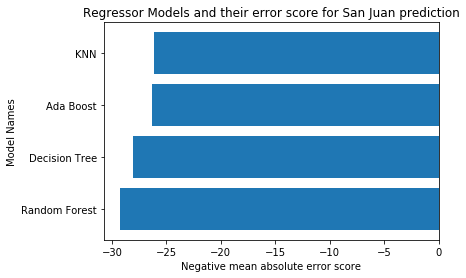

In [18]:
plt.barh(sj_score.model, sj_score.sj_score)
plt.ylabel("Model Names")
plt.xlabel("Negative mean absolute error score")
plt.title("Regressor Models and their error score for San Juan prediction")

Text(0.5, 1.0, 'Regressor Models and their error score for Iquitos prediction')

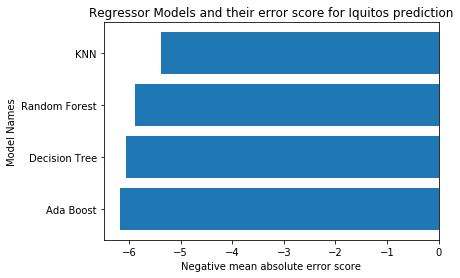

In [19]:
plt.barh(iq_score.model, iq_score.iq_score)
plt.ylabel("Model Names")
plt.xlabel("Negative mean absolute error score")
plt.title("Regressor Models and their error score for Iquitos prediction")

To assess the performance for different parameters, we visualize the scores of RandomForestRegressor with different parameters. We can see that the scores on the diagonal line tends to be the most inaccurate ones and the ones around it tend to be accurate around -27 and -28, then the further the point is, the more inaccurate it is. This is a really intersting pattern showing that the relationship between the scores and these parameters are not linear but has some statistical regularity in it. 

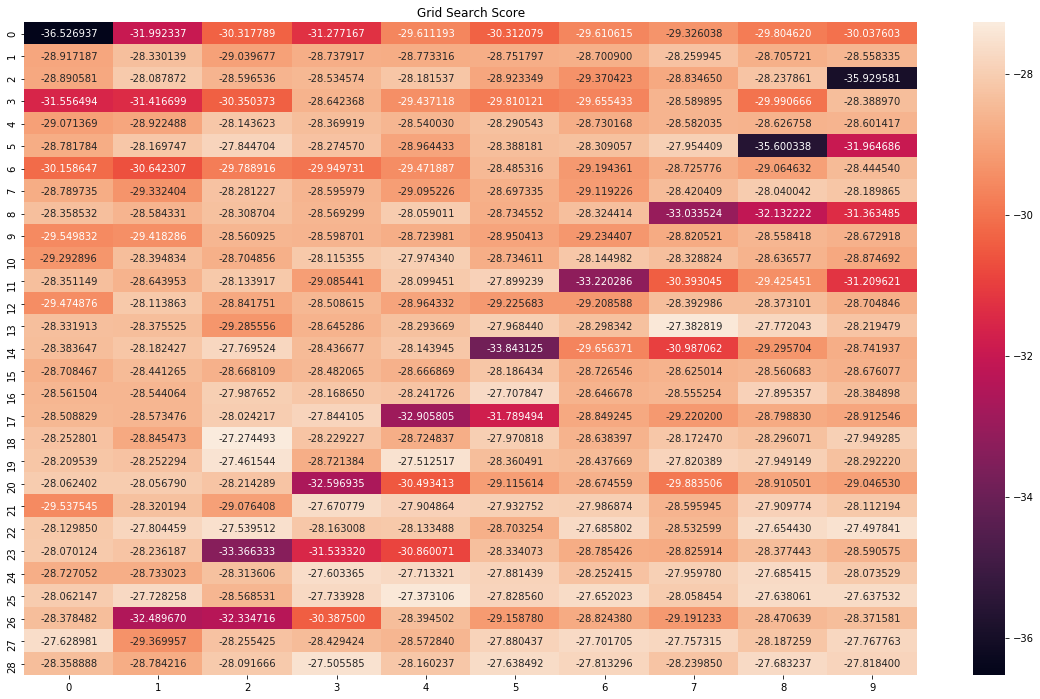

In [20]:
n_estimators = [i for i  in range(1, 30)]
min_samples_split = [j for j in range(5, 15)]
scores = grid_rf.cv_results_['mean_test_score'].reshape(len(n_estimators),len(min_samples_split))
plt.figure(figsize=(20, 12))
plt.xticks(np.arange(len(min_samples_split)), min_samples_split)
plt.yticks(np.arange(len(n_estimators)), n_estimators)
plt.title('Grid Search Score')
plt.xlabel('n_estimators')
plt.ylabel('min_samples_split')
sns.heatmap(scores, annot=True,fmt="f")
plt.show()


From the visualizations we fund that for both cities, KNN is the best model, so we decided to predict the final test data file with it.

In [ ]:
#Final Prediction
#add useful features to the test data file
lagged_week = []
for week_num in sj_test['weekofyear']:
    if week_num <= 4:
        week_num += 48
        lagged_week.append(week_num)
    else: 
        week_num -= 4
        lagged_week.append(week_num)
sj_test['one_month_lagged_week'] = lagged_week

lagged_week = []
for week_num in iq_test['weekofyear']:
    if week_num <= 12:
        week_num += 40
        lagged_week.append(week_num)
    else: 
        week_num -= 12
        lagged_week.append(week_num)
iq_test['three_month_lagged_week'] = lagged_week

submission = pd.read_csv("data/submission_format.csv", index_col=[0, 1, 2])

knn_reg_iq = KNeighborsRegressor(n_neighbors = knn_result[2].get('kneighborsregressor__n_neighbors'),
                                 weights = knn_result[2].get('kneighborsregressor__weights'))
knn_reg_sj = KNeighborsRegressor(n_neighbors = knn_result[3].get('kneighborsregressor__n_neighbors')
                                 , weights = knn_result[3].get('kneighborsregressor__weights'))

def final_fit_and_predict(sj_regressor,iq_regressor):
    sj_reg_fit= sj_regressor.fit(sj_ds_uni.drop('cases', axis=1),sj_ds_uni['cases'])
    iq_reg_fit= iq_regressor.fit(iq_ds_uni.drop('cases', axis=1),iq_ds_uni['cases'])
    sj_pred = sj_regressor.predict(sj_test[list(sj_ds_uni.drop('cases', axis=1))]).astype(int)
    iq_pred = iq_regressor.predict(iq_test[list(iq_ds_uni.drop('cases', axis=1))]).astype(int)
    
    submission.total_cases = np.concatenate([sj_pred, iq_pred])
    submission.to_csv("data/final_result.csv")
    
final_fit_and_predict(knn_reg_sj,knn_reg_iq)